Royen Clément

Demanou Daniel

<h1><center> Restauration d'image à l'aide de l'ADMM </center></h1>

<h2> 1 - Altération d'une image </h2>

### Manipulation 1

Importons les données du problème.

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from scipy.sparse.linalg import inv as sinv
import scipy.sparse as sp
%matplotlib inline

data = pickle.load(open('datasparse.pk','rb'))
print "Description de datasparse.pk %s" %data.viewkeys()
H = data.get('H')
T = data.get('T')
filtre = data.get('filtre')
img = data.get('original')

Description de datasparse.pk dict_keys(['H', 'filtre', 'observations', 'original', 'T'])


L'image contenue dans la matrice $\text{observation}$ n'est pas conforme à la transformation induite par le filtre. On obtient la matrice d'observation en refiltrant l'image d'origine par $H$. 

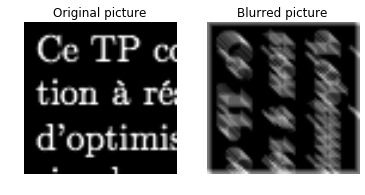

In [2]:
obs = H.dot(img.reshape((img.shape[0]**2,))).reshape((img.shape[0],img.shape[0]))

plt.figure(1)
plt.subplot(121)
plt.imshow(img,cmap='Greys')
plt.title("Original picture")
plt.axis('off')

plt.subplot(122)
plt.imshow(obs,cmap='Greys')
plt.title("Blurred picture")
plt.axis('off')
plt.show()

L'image a subit une rotation de $\text{90°}$, une symétrie axiale et un floutage.

### Préparation 1

On pose $$A = \begin{pmatrix} I_P \\ T \end{pmatrix} \ \text{et} \ B = -I_{3P - K - L}$$.
Alors $$Ax = \begin{pmatrix} x \\ Tx \end{pmatrix} \ \text{et}\ Bz = -z = \begin{pmatrix} -z_1 \\ -z_2 \end{pmatrix}$$

Ainsi 
$$
(3) \Leftrightarrow \underset{(x, z_1, z_2) \in \mathbb{R}^P \times \mathbb{R}^{P} \times \mathbb{R}^{2P-K-L} }{\text{min}} \frac{1}{2} \left \| y-Hx \right \|_2^2 +\beta \left \|  z_2 \right \|_1 + i_{\mathbb{R}_+}(z_1)\\ 
\text{s.c} \ \ z_1 - x = 0 \ \text{et} \ z_2 - Tx = 0
$$

i.e

$$
(3) \Leftrightarrow \underset{(x, z_1, z_2) \in \mathbb{R}^P \times \mathbb{R}^{P} \times \mathbb{R}^{2P-K-L} }{\text{min}} \frac{1}{2} \left \| y-Hx \right \|_2^2 +\beta \left \|  z_2 \right \|_1 + i_{\mathbb{R}_+}(z_1)\\ 
\text{s.c} \ \ Ax + Bz = 0
$$

On note $ f : x \mapsto \frac{1}{2} \left \|  y-Hx\right \|_2^2 $ et $g : z=(z_1,z_2) \mapsto \beta \left \|z_2 \right \|_1 + i_{\mathbb{R}_+}(z_1)$

Alors 
$$
(3) \Leftrightarrow \underset{(x, z) \in \mathbb{R}^P \times \mathbb{R}^{3P-K-L}}{\text{min}} f(x) +g(z)\\ 
\text{s.c} \ \ Ax + Bz=0
$$


### Préparation 2

Nous n'avons qu'une contrainte d'égalité. Le lagrangien augmenté du problème $\text{(5)}$ s'écrit:

$$ \forall (x,z,\gamma) \in \mathbb{R}^P \times \mathbb{R}^{3P-K-L} \times \mathbb{R}^{3P-K-L} 
\ \ \mathcal{L}_\rho(x,z,\gamma) = f(x) + g(z) + \left \langle \gamma, Ax+Bz \right \rangle + \frac{\rho}{2}\left \| Ax+Bz \right \|_2^2 \ \ (6)$$

ou encore 
$$\mathcal{L}_\rho(x,z,\gamma) = f(x) + g(z) + \left \langle \gamma, Ax \right \rangle - \left \langle \gamma, z \right \rangle + \frac{\rho}{2}\left \| Ax - z \right \|_2^2$$

finalement
$$
\mathcal{L}_\rho(x,(z_1,z_2),(\gamma_1,\gamma_2)) = \frac{1}{2} \left \| y-Hx \right \|_2^2 + \beta \left \|  z_2 \right \|_1 + i_{\mathbb{R}_+}(z_1) + \left \langle \gamma, Ax \right \rangle - \left \langle \gamma_1, z_1 \right \rangle - \left \langle \gamma_2, z_2 \right \rangle + \frac{\rho}{2}\left \| x - z_1 \right \|_2^2 + \frac{\rho}{2}\left \| Tx - z_2 \right \|_2^2
$$

### Préparation 3

L'ADMM s'écrit pour tout $k$ à l'itération $k+1$:
$$ \begin{aligned} 
& x^{k+1} = \underset{x}{\text{arg min}} \ \ \mathcal{L}_\rho(x,z^k,\gamma^k) \\
& z^{k+1} = \underset{z}{\text{arg min}} \ \ \mathcal{L}_\rho(x^{k+1},z,\gamma^k) \\
& \gamma^{k+1} = \gamma^k + \rho(Ax^{k+1} - z^{k+1}) \\
\end{aligned}
$$

C'est à dire:

$$ \begin{aligned} 
& x^{k+1} = \underset{x}{\text{arg min}} \ \frac{1}{2} \left \|y-Hx \right \|_2^2 + \left \langle \gamma^k,Ax \right \rangle + \frac{\rho}{2} \left \| Ax - z^k \right \|_2^2 \\
& z^{k+1} = (z_1^{k+1},z_2^{k+1}) = \underset{(z_1,z_2)}{\text{arg min}} \ \ \beta \left \| z_2 \right \|_1 + i_{\mathbb{R}_+}(z_1) - \left \langle \gamma_1,z_1 \right \rangle - \left \langle \gamma_2,z_2 \right \rangle + \frac{\rho}{2} \left \| x^{k+1}-z_1 \right \|_2^2 + \frac{\rho}{2} \left \| Tx^{k+1} - z_2 \right \|_2^2 \\
& \gamma^{k+1} = \gamma^k + \rho(Ax^{k+1} - z^{k+1})
\end{aligned}
$$


Pour l'itération de $x$ on remarque que la fonction à minimiser est différentiable et convexe car la composition $g\circ U$ d'une fonction affine $U$ par une fonction convexe $h$ est convexe puis une somme positive de fonction convexe est convexe. Donc il y a un minimum atteint lorsque le gradient est nul c'est-à-dire que $k^{k+1}$ vérifie:

$$\begin{aligned}
0 &= -H^T(y-Hx) + A^T\gamma^k + \rho A^T(Ax^{k+1}-z^k) \\
& = -H^Ty + A^T\gamma^k - \rho A^Tz^k + (H^TH + \rho A^TA)x^{k+1}
\end{aligned}
$$

Or $A^TA = I_P + T^TT$ donc $A^TA$ est somme d'une matrice symétrique définie positive ($I$) et d'une matrice symétrique positive ($T^TT$) donc $A^TA$ est symétrique définie positive. Par le même argument $H^TH + A^TA$ l'est aussi et est donc inversible. D'où:

$$
x^{k+1} = (H^TH + \rho A^TA)^{-1}(H^Ty - A^T\gamma^k + \rho A^Tz^k) \ \ (7)
$$

### Préparation 4

D'après la question précédente comme les variables $z_1$ et $z_2$ peuvent être séparées on peut optimiser selon $z$ en optimisant en $z_1$ et $z_2$ séparément. Cela nous donne:

$$
\begin{aligned}
z_1^{k+1} & = \underset{z}{\text{arg min}} \ \ i_{\mathbb{R}_+}(z) - \left \langle \gamma_1,z \right \rangle + \frac{\rho}{2} \left \| x^{k+1}z \right \|_2^2 \\
& =  \underset{z}{\text{arg min}} \ \ i_{\mathbb{R}_+}(z) - \left \langle \gamma_1,z \right \rangle + \frac{\rho}{2} \left \| x^{k+1}z \right \|_2^2 + \frac{1}{2 \rho} \left \| \gamma_1 \right \|_2^2 + \left \langle \gamma_1, x^{k+1}\right \rangle \\
& =  \underset{z}{\text{arg min}} \ \ i_{\mathbb{R}_+}(z) + \frac{\rho}{2} \left \| x^{k+1}z \right \|_2^2 - \rho \left \langle \frac{1}{\rho} \gamma_1,z-x^{k+1}\right \rangle + \frac{\rho}{2} \left \| \frac{1}{\rho} \gamma_1 \right \|_2^2 \\
& = \underset{z}{\text{arg min}} \ \ i_{\mathbb{R}_+}(z) + \frac{\rho}{2}\left \| \frac{1}{\rho}\gamma_1+x^{k+1}- z \right \|_2^2 \\
& = \text{prox}_{\frac{1}{\rho} i_{\mathbb{R}_+}}(\frac{1}{\rho}\gamma_1 + x)
\end{aligned}
$$

de même

$$
\begin{aligned}
z_2^{k+1} & = \underset{z}{\text{arg min}} \ \ \beta \left \| z  \right \|_1 - \left \langle \gamma_2,z \right \rangle + \frac{\rho}{2} \left \| Tx^{k+1}- z \right \|_2^2 \\
& = \underset{z}{\text{arg min}} \ \beta \left \| z  \right \|_1 + \frac{\rho}{2}\left \| \frac{1}{\rho}\gamma_2+Tx^{k+1}- z \right \|_2^2 \\
& = \text{prox}_{\frac{1}{\rho}\beta \left \| . \right \|_1}(\frac{1}{\rho}\gamma_2+Tx^{k+1})
\end{aligned}
$$

Avec les opérateurs proximaux des deux fonctions intervenant:
$$
\forall x \in \mathbb{R}^n, \ \text{prox}_{i_{\mathbb{R}_+}}(x) = ( \text{max}(0,x_i) )_{i=1..n}
$$ 
et
$$
\forall x \in \mathbb{R}^n, \ \text{prox}_{\beta \left \| . \right \|_1}(x) = ( \text{max}(0,1 - \beta \frac{1}{|x_i|})x_i )_{i=1..n}
$$

D'où
$$
\begin{aligned}
& z_2^{k+1} =\left [ \text{max} \left ( 0,1 - \frac{1}{\rho}\beta \frac{1}{|(Tx^{k+1})_i + \frac{1}{\rho} \gamma_{2,i}^k |} \right )\times \left ((Tx^{k+1})_i +  \frac{1}{\rho} \gamma_{2,i}^k \right ) \right ]_{i=1..2P-K-L} (8) \\
& z_1^{k+1} = \left [ \text{max} \left ( 0,x_i^{k+1} + \frac{1}{\rho}\gamma_{1,2}^k \right ) \right ]_{i=1..P} (9)
\end{aligned}
$$

### Préparation 5

D'après la question 3 on avait 
$$
\begin{aligned}
& \gamma^{k+1} = \gamma^k + \rho(Ax^{k+1} - z^{k+1}) \\
\end{aligned}
$$
D'où 
$$
\begin{aligned}
& \gamma_1^{k+1} = \gamma_1^k + \rho(x^{k+1} - z_1^{k+1}) \ \ \ (10)\\
& \gamma_2^{k+1} = \gamma_2^k + \rho(Tx^{k+1} - z_2^{k+1}) \ \ \ (11)
\end{aligned}
$$

### Manipulation 2

On vectorise les images.

In [3]:
K,L = img.shape # dimension 64x64
P = K*L # dimension 4096
x_true = img.reshape((P,)) # true picture vectorized
y = obs.reshape((P,)) # blurred and turned observed picture

Implémentons maintenant l'algorithme d'optimisation. Nous avons besoin de coder $A$, $B$, $f$, $g$, $\mathcal{L}_\rho$, $\text{prox}_{i_{\mathbb{R}_+}}$, $\text{prox}_{\beta \left \| . \right \|_1}$. On utilisera au maximum les fonction du package $scipy.sparse$ pour plus de rapidité.

In [4]:
A = sp.vstack([sp.csr_matrix(np.eye(K*L)),T]) # matrix in mapping (7)
B = - sp.eye(3 * P - K - L) # matrix in mapping (7)

## initialize
beta = 0.01
rho=0.1
k_max = 100

## matrix in mapping (7) which does not depend on any variable
C = sinv(H.T.dot(H) + rho * A.T.dot(A))

def f(x):
    """""
    Compute f(x)

    parameters:
    -------
    x : array of shape (P,)
    
    return
    -------
    f(x) : float
    """""
    return 0.5 * norm(y - H.dot(x))

def g(z1,z2):
    """""
    Compute g(z)=g(z1,z2)= beta*||z2||_1 + i_R+(z1)

    parameters:
    -------
    z1 : array of shape (P,)
    z2 : array of shape (2P-K-L,)
    
    return
    -------
    g(z) : float
    """""
    
    if( (z1 < 0).any() ):
        u = np.inf
    else:
        u = 0
        
    return beta * norm(z2,1)  +  u

def loss(x):
    """""
    Compute loss(x) = f(x) + g(x,Tx) = 0.5 * ||y-Hx||_1^2 + beta*||Tx||_1 + i_R+(x)

    parameters:
    -------
    x : array of shape (P,)
    
    return
    -------
    loss(x) : float
    """""
    return f(x) + g(x,T.dot(x))

def Lagrangien(x,z1,z2,gamma1,gamma2):
    """""
    Compute L_rho(x,z,gamma) of (6) = f(x) + g(z1,z2) + <gamma,Ax + Bz> + 0.5*rho*||Ax+Bz||_2^2

    parameters:
    -------
    x : array of shape (P,)
    z1 : array of shape (P,)
    z2 : array of shape (2P - K - L,)
    gamma1 : array of shape (P,)
    gamma2  array of shape (2P-K-L)
    
    return
    -------
    L_rho(x,z,gamma) : float
    """""
    z = np.r_[z1,z2]
    gamma = np.r_[gamma1,gamma2]
    C = A.dot(x) + B.dot(z)
    
    return f(x) + g(z1,z2) + gamma.dot(C) + rho / 2 * norm(C)**2

def prox_ind(x,gamma):
    """""
    Compute prox_ind(x,gamma) for mapping (9)

    parameters:
    -------
    x : array of shape (P,)
    gamma=gamma1 : array of shape (P,)
    
    return
    -------
    prox_ind(x,gamma) : float
    """""
    return np.array([ max(0,u + v / rho) for (u,v) in zip(x,gamma)])

def prox_norm(x,gamma):
    Tx = T.dot(x)
    """""
    Compute prox_norm(x,gamma) for mapping (8)

    parameters:
    -------
    x : array of shape (P,)
    gamma=gamma2 : array of shape (2P-K-L,)
    
    return
    -------
    prox_norm(x,gamma) : float
    """""
    return np.array([ max(0,1 - beta / rho * 1. / abs(u + v/rho))*(u + v/rho) for (u,v) in zip(Tx,gamma)])

Puis on code la fonction $\text{trainOne}$ qui met à jour les variables selon $(7), (8), (9), (10)$ et $(11)$. Le tout est bouclé dans la fonction $\text{train}$ qui stocke en plus à chaque itération la valeur du Lagrangien, de l'erreur quadratique moyenne et le biais à l'aide de la fonction $\text{EvalError}$ qui calcule le biais et l'EQM à un instant donné.

In [8]:
def trainOne(x,y,z1,z2,gamma1,gamma2):
    """""
    Does (7), (8), (9), (10), (11)

    parameters:
    -------
    x : current state of x, array of shape (P,)
    y : observation of shape (P,)
    z1 : current state of z1, array of shape (P,)
    z2 : current state of z2, array of shape (2P-K-L,)
    gamma1 : current state of gamma1, array of shape (P,)
    gamma2 : current state of gamma2, array of shape (2P-K-L,)
    
    return
    -------
    x,z1,z2,gamma1,gamma2 : actualised states of variables
    """""
    
    gamma = np.r_[gamma1,gamma2]
    z = np.r_[z1,z2]
    
    D = H.T.dot(y) - A.T.dot(gamma) + rho * A.T.dot(z)
    
    # Update
    x = C.dot(D)
    z1 = prox_ind(x,gamma1)
    z2 = prox_norm(x,gamma2)
    gamma1 = gamma1 + rho * (x - z1)
    gamma2 = gamma2 + rho * (T.dot(x) - z2)
    
    return x,z1,z2,gamma1,gamma2
    
def train(x0,y,z10,z20,gamma10,gamma20,k_max):
    
    """""
    Loop of (7), (8), (9), (10), (11). Does the optimization and catch at each step EQM, bias, value of Lagrangien
    
    parameters:
    -------
    x0 : previous state of x, array of shape (P,)
    y : observation of shape (P,)
    z10 : current state of z1, array of shape (P,)
    z20 : current state of z2, array of shape (2P-K-L,)
    gamma10 : current state of gamma1, array of shape (P,)
    gamma20 : current state of gamma2, array of shape (2P-K-L,)
    k_max : number of iteration
    
    return
    -------
    x,z1,z2,gamma1,gamma2 : final optimal point of Lagrangien
    EQM : list of EQM of x over iteration, length = k_max + 1
    bias : list of bias of x over iteration, length = k_max + 1
    lagr_value : list of Lagrangien value at x over iteration, length = k_max + 1
    """""
    
    x = x0.copy()
    z1 = z10.copy()
    z2 = z20.copy()
    gamma1 = gamma10.copy()
    gamma2 = gamma20.copy()
    
    EQM = []
    bias = []
    lagr_value = []
    
    EQM.append(EvalError(x,x_true)[0])
    bias.append(EvalError(x,x_true)[1])
    lagr_value.append(Lagrangien(x,z1,z2,gamma1,gamma2))
    
    for k in range(k_max):
        x,z1,z2,gamma1,gamma2 = trainOne(x,y,z1,z2,gamma1,gamma2)
        EQM.append(EvalError(x,x_true)[0])
        bias.append(EvalError(x,x_true)[1])
        lagr_value.append(Lagrangien(x,z1,z2,gamma1,gamma2))
    
    return x,z1,z2,gamma1,gamma2,EQM,bias,lagr_value
    
def EvalError(x1,x2):
    
    """""
    Compute EQM and bias between x1 and x2

    parameters:
    -------
    x1 : array of shape (P,)
    x2: array of shape (P,)
    
    return
    -------
    EQM : float
    bias : array of shape (P,)
    """""
    
    p = x1.shape[0]
    EQM = 1. / p * norm(x1-x2)**2
    bias = x1-x2
    
    return EQM, bias

Enfin on code une fonction qui affiche les résultats retournés par la fonction $\text{train}$.

In [25]:
def printresults(x,EQM,bias,lagr_value,k):
    """""
    Print the results of one train return
    """""
    
    print "Nombre d'itération: %s" %k
    print "EQM final: %s" %EQM[-1]
    print "Biais final: %s" %bias[-1]
    print "Valeur finale du lagrangien: %s" %lagr_value[-1]

    plt.figure(1,figsize=(8,16))
    plt.subplot(131)
    plt.imshow(x.reshape((K,L)),cmap='Greys')
    plt.axis('off')
    plt.title("Image reconstruite")
    plt.subplot(132)
    plt.imshow(x_true.reshape((K,L)),cmap='Greys')
    plt.axis('off')
    plt.title("Image originale")
    plt.subplot(133)
    plt.imshow(y.reshape((K,L)),cmap='Greys')
    plt.axis('off')
    plt.title("Observation")

    plt.figure(2,figsize=(12,5))
    plt.subplot(121)
    plt.plot(range(k+1),np.log(np.array(EQM)))
    plt.xlabel("iterations")
    plt.ylabel("EQM (echelle log)")
    plt.title("Evolution de l'EQM")
    plt.subplot(122)
    plt.plot(range(k+1),lagr_value)
    plt.xlabel("iterations")
    plt.ylabel("Lagrangien")
    plt.title("Evolution du lagrangien")

On peut maintenant tester l'algorithme:

Temps d'exécution: 2.471699 s
Nombre d'itération: 60
EQM final: 0.00784152603207
Biais final: [ 0.00417181  0.00624868  0.00693985 ..., -0.00592405 -0.00603896
 -0.00539112]
Valeur finale du lagrangien: 64.3712086696


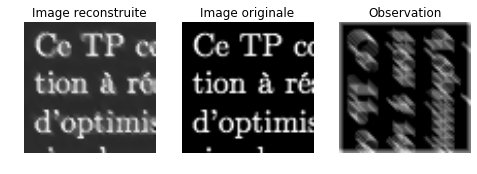

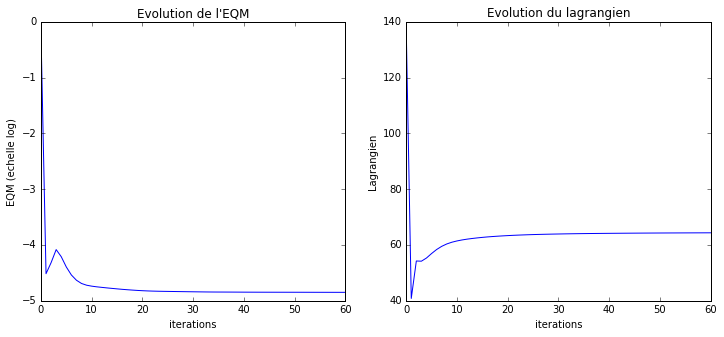

In [26]:
x0 = np.zeros((P,))
z10 = np.zeros((P,))
z20 = np.zeros((2*P - K - L,))
gamma10 = np.zeros((P,))
gamma20 = np.zeros((2*P - K - L,))
beta = 0.1
rho=0.1
k = 60

import time
t = time.clock()

x,z1,z2,gamma1,gamma2,EQM,bias,lagr_value = train(x0,y,z10,z20,gamma10,gamma20,k)

print "Temps d'exécution: %s s" %(time.clock() - t)
printresults(x,EQM,bias,lagr_value,k)

On a affiché les résultat en niveau de gris pour mieux voir les informations. On remarque que l'image calculée est défloutée et bien réorientée mais qu'elle comporte aussi un masque blanc, ce qui signifie que le terme en $\beta \left \| Tx \right \|_1$ a trop propagé la minimisation de la différence entre les prixels voisins. On s'attend à ce que lorsque beta diminue on retire ce masque.

In [14]:
print "valeur moyenne du biais %s" %np.mean(abs(bias[-1]))
print "valeur maximale du biais %s" %max(abs(bias[-1]))

valeur moyenne du biais 0.0481550588739
valeur maximale du biais 0.612389549978


Cela est traduit par une valeurs du biais de l'ordre de 0.04 en moyenne pour une valeur maximale de 0.6 pour les composantes.

En ce qui concerne la convergence, lorsque l'on observe les courbe de l'EQM et de la valeur du Lagrangien on remarque que l'algorithme converge en une vingtaine d'itérations (voire plus mais peu sensiblement). Soit en 1.3 secondes sur notre machine. C'est assez rapide mais le résultat n'est pas satisfaisant. Nous allons maintenant étudier les variations des résultats en fonction des paramètres $\beta$ et $\rho$. On s'attend à ce qu'avec des bons paramètres on fasse baisser l'EQM (car on enlèvera le masque qui répartit l'erreur sur l'ensemble des pixels).

### Manipulation 4

Afin d'étudier l'influence de $\beta$ et de $\rho$ on va créer une grille de paramètres. On les fera varier entre 0.001 et 0.2.

In [15]:
beta_list = [0.001,0.01,0.1,0.2]
rho_list = [0.001,0.01,0.1,0.2]

Enregistrons les courbes de l'EQM et du Lagrangien ainsi que les temps d'exécution, les biais et les images calculées pour $\beta$ et $\rho$ variant dans la grille ci-dessus.

In [27]:
from itertools import product
k = 60
x_list = []
EQM_list = []
bias_list = []
lagr_value_list = []
time_list = []
for (i,j) in product(range(4), repeat=2):
    beta = beta_list[i]
    rho = rho_list[j]
    t = time.clock()
    x,z1,z2,gamma1,gamma2,EQM,bias,lagr_value = train(x0,y,z10,z20,gamma10,gamma20,k)
    t = time.clock() - t
    x_list.append(x)
    EQM_list.append(EQM)
    bias_list.append(bias)
    lagr_value_list.append(lagr_value)
    time_list.append(t)

Représentons les temps d'exécution sous la forme d'un tableau

In [29]:
import pandas as pd
index = ['beta = 0.001', 'beta = 0.01', 'beta = 0.1','beta = 0.2']
data = np.array([time_list[0:4],time_list[4:8],time_list[8:12],time_list[12:16]])
col = ['rho = 0.001','rho = 0.01','rho = 0.1','rho = 0.2']
df_time = pd.DataFrame(data=data,index=index,columns=col)
df_time.head()

,rho = 0.001,rho = 0.01,rho = 0.1,rho = 0.2
beta = 0.001,2.405216,2.291345,2.609853,2.651993
beta = 0.01,2.381854,2.297051,2.305217,2.257019
beta = 0.1,2.325098,2.317248,2.316135,2.308999
beta = 0.2,2.313411,2.319229,2.316348,2.307576


On remarque que lorsque $\beta$ est très petit le temps d'exécution est élevé. Mais ce n'est pas une règle car il n'y a pas de décroissance dans quelque sens que ce soit. On s'attendait pourtant à ce que l'inversion de la matrice intervenant dans l'expression des $x_k$ alourdisse le temps de calcul lorsque rho diminue car celle-ci se rapproche plus d'une matrice potentiellement non inversible. Mais ce n'est pas le cas.

Représentons les images calculées sous la forme d'une grille dans le même ordre que le tableau des temps d'exécution. Obersons la relation entre le temps de calcul et la qualité de la reconstruction.

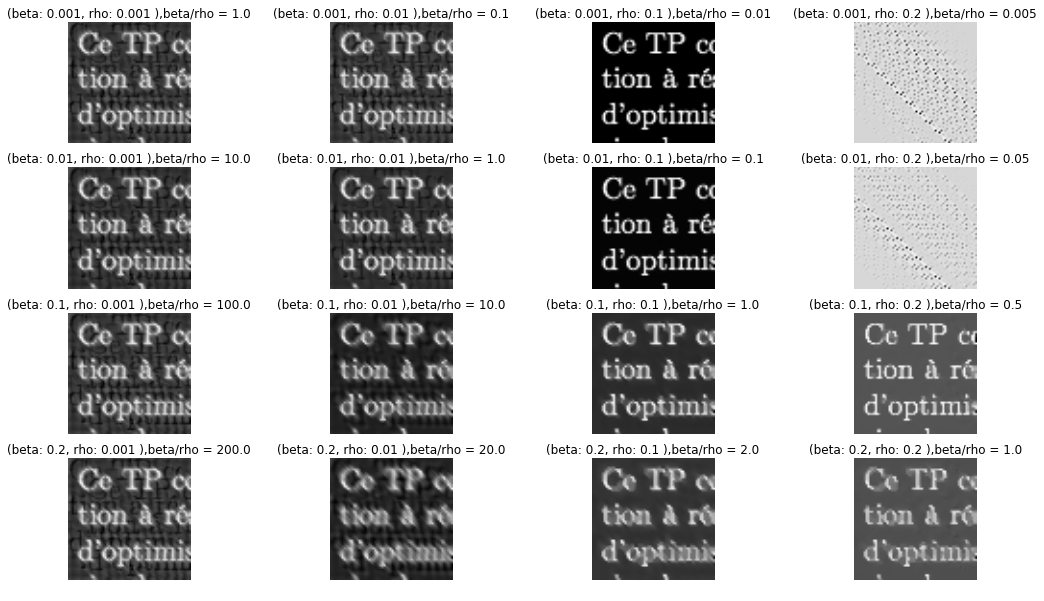

In [42]:
plt.figure(1,figsize=(18,10))
for (i,j) in product(range(4),repeat = 2):
    plt.subplot(4,4,4*i + j+1)
    plt.imshow(x_list[4*i + j].reshape((K,L)),cmap='Greys')
    plt.title("(beta: %s, rho: %s ),beta/rho = %s"%(beta_list[i],beta_list[j],beta_list[i] / rho_list[j]))
    plt.axis('off')
    

Le meilleur résultat est obtenu pour $\beta = 0.001$ et $\rho = 0.1$. Ce qui corrobore la remarque faite sur le masque blanc du résultat de la question 3. On remarque que pour $\rho$ assez grand mais pas trop grand la reconstruction est d'autant meilleure que $beta$ est petit. 

En effet lorsque $\beta$ diminue le contraste augmente (le masque disparaît).

On observe aussi que lorsque $\rho$ augmente l'image devient plus nette.

Mais lorsque le rapport $\frac{\beta}{\rho}$ est trop petit la qualité de la reconstruction est mauvaise. Ce rapport intervient dans l'expression de l'opérateur proximal pour calculer $z_2$. On imagine que lorsqu'il est trop petit $z_2$ n'a jamais de composante nulle au cours des itérations, ce qui explique un probable phénomène de divergence.


Observons alors l'évolution de la descente au cours des itérations.

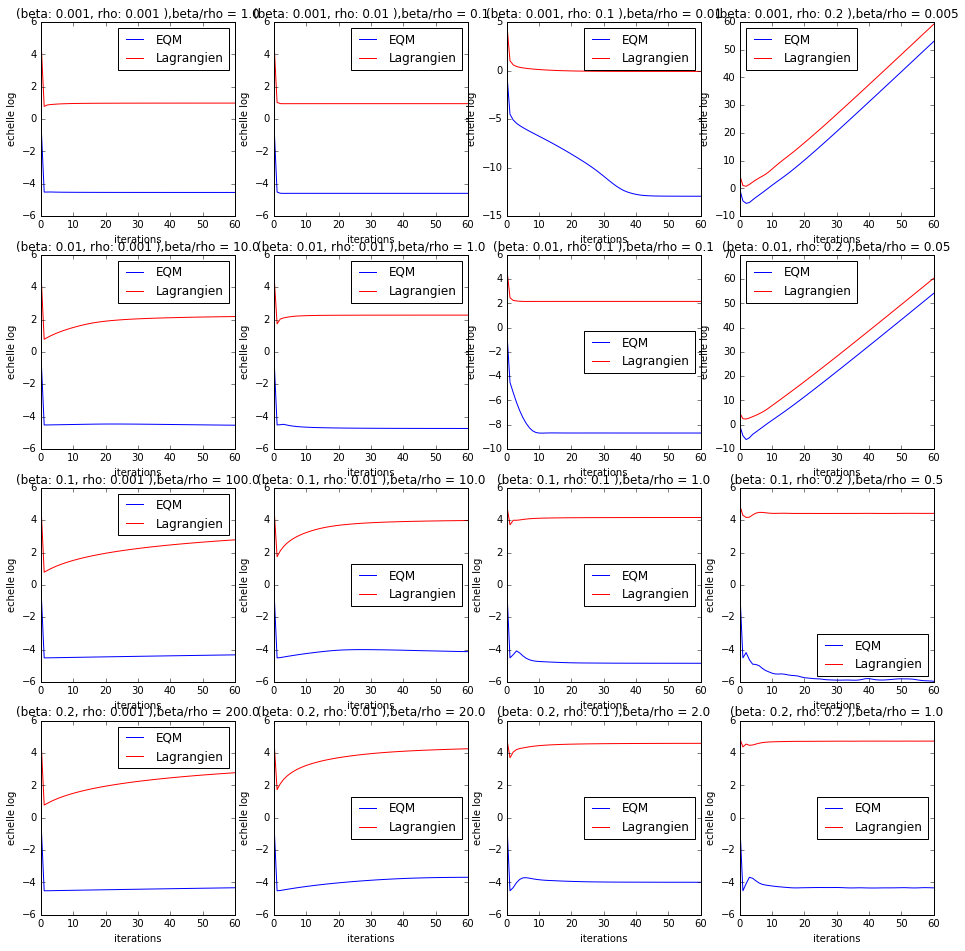

In [43]:
plt.figure(1,figsize=(16,16))
for (i,j) in product(range(4),repeat = 2):
    plt.subplot(4,4,4*i + j+1)
    plt.plot(range(k+1),np.log(EQM_list[4*i+j]),'b',label='EQM')
    plt.plot(range(k+1),np.log(lagr_value_list[4*i+j]),'r',label='Lagrangien')
    plt.legend(loc='best')
    plt.xlabel("iterations")
    plt.ylabel("echelle log")
    plt.title("(beta: %s, rho: %s ),beta/rho = %s"%(beta_list[i],beta_list[j],beta_list[i] / rho_list[j]))
    

On observe en effet une divergence lorsque le rapport $\frac{\beta}{\rho}$ est trop petit. On observe aussi que la convergence est d'autant plus rapide que le rapport est grand et que $\rho$ est petit. Ainsi la convergence est plus lente lorsque l'on souhaite une bonne qualité de reconstruction (40 itérations pour un EQM à $10^{-13}$ pour $\beta = 0.001$ et $\rho = 0.1$.

Observons enfin les biais.

In [31]:
index = ['beta = 0.001', 'beta = 0.01', 'beta = 0.1','beta = 0.2']
data = np.zeros((4,4))
for (i,j) in product(range(4),repeat=2):
    data[i,j] = max(abs(bias_list[4*i+j][-1]))
col = ['rho = 0.001','rho = 0.01','rho = 0.1','rho = 0.2']
df_bias = pd.DataFrame(data=data,index=index,columns=col)
df_bias.head()

,rho = 0.001,rho = 0.01,rho = 0.1,rho = 0.2
beta = 0.001,0.422153,0.410417,0.013844,1.968177e+12
beta = 0.01,0.447603,0.429349,0.119692,4.522702e+12
beta = 0.1,0.473644,0.631165,0.610115,5.498945e-01
beta = 0.2,0.473644,0.679762,0.674997,6.632759e-01


In [32]:
index = ['beta = 0.001', 'beta = 0.01', 'beta = 0.1','beta = 0.2']
data = np.zeros((4,4))
for (i,j) in product(range(4),repeat=2):
    data[i,j] = np.mean(abs(bias_list[4*i+j][-1]))
col = ['rho = 0.001','rho = 0.01','rho = 0.1','rho = 0.2']
df_bias = pd.DataFrame(data=data,index=index,columns=col)
df_bias.head()

,rho = 0.001,rho = 0.01,rho = 0.1,rho = 0.2
beta = 0.001,0.076253,0.074435,0.000766,1.879736e+11
beta = 0.01,0.074930,0.064804,0.006427,3.426260e+11
beta = 0.1,0.082825,0.078588,0.046527,2.280652e-02
beta = 0.2,0.082825,0.100411,0.073431,5.898974e-02


Là aussi le biais est optimal lorsque $\rho = 0.1$ et $\beta = 0.001$.

### Conclusion:

L'optimalité de la solution s'obtient en jouant sur les paramètres $\beta$, $\rho$ et $\frac{\beta}{\rho}$. Les causes d'une bonne reconstruction sont un équilibre entre le rapport et $\rho$. Il faut qu'ils soient faibles tous les deux et le temps de calcul est plus long.